# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
from google.colab import files
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Loading the Files

Download the csv files into the `data/` directory.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When

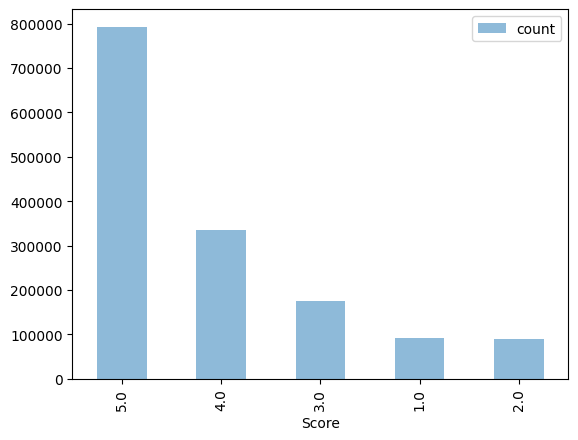


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
from google.colab import drive
drive.mount('/content/drive')

trainingSet = pd.read_csv("/content/drive/My Drive/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
# Feature extraction function
def add_features_to(df):
    # Fill NaN values in the 'Text' column with empty strings
    df['Text'] = df['Text'].fillna('')

    # Helpfulness feature
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review Length as a feature and avg word length
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['AvgWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

    return df

# Load pre-processed data if available
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

# Save processed data
if not os.path.exists('./data'):
    os.makedirs('./data')
X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

In [7]:
#Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_select = scaler.fit_transform(X_train_select)
X_test_select = scaler.transform(X_test_select)
X_submission_select = scaler.transform(X_submission_select)

In [8]:
#Dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=4)  # Set n_components to 3 or any number <= number of features
X_train_select = pca.fit_transform(X_train_select)
X_test_select = pca.transform(X_test_select)
X_submission_select = pca.transform(X_submission_select)


# Model Creation

In [9]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=500).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

In [10]:
# cross validation
cv_scores = cross_val_score(model, X_train_select, Y_train, cv=50, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

Cross-Validation Accuracy Scores: [0.55253355 0.55302724 0.55495714 0.55284772 0.55181545 0.55359066
 0.55305206 0.552693   0.5513465  0.55264811 0.55341113 0.55412926
 0.55228905 0.55246858 0.55525135 0.55251346 0.55363555 0.55399461
 0.55417415 0.55089767 0.55345601 0.55435368 0.55260323 0.5532316
 0.55341113 0.55359066 0.55143627 0.55341113 0.55372531 0.55192998
 0.55157092 0.55336625 0.55354578 0.5518851  0.5521544  0.55417415
 0.5540395  0.55175045 0.55206463 0.55372531 0.5529623  0.5535009
 0.5524237  0.55417415 0.55219928 0.55044883 0.5510772  0.55327648
 0.55251346 0.55394973]
Mean Cross-Validation Accuracy: 0.5529445554927325
Accuracy on testing set =  0.5525319387293448


# Model Evaluation

Accuracy on testing set =  0.5525319387293448


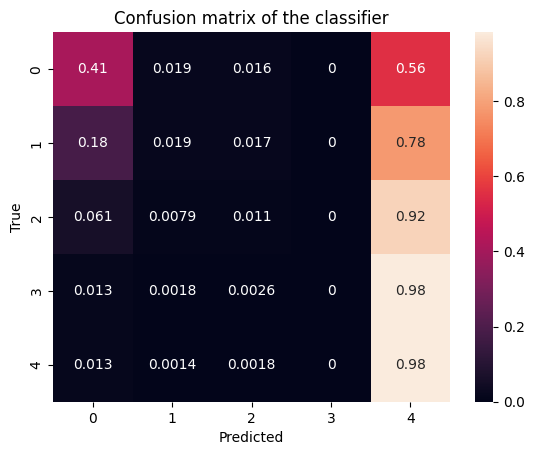

In [11]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [12]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
from google.colab import files
files.download("./data/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>